In [124]:

import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import os
import sys
import argparse
os.chdir('../')
sys.path.append('./')
os.getcwd()
from models.swinjscc import SWINJSCC 
from models.djsccn import DJSCCN_CIFAR
from models.eDjscc import *
import matplotlib.pyplot as plt
from utils.misc_utils import get_psnr, image_normalization

In [125]:
parser = argparse.ArgumentParser()
parser.add_argument('--out', type=str, default='./out',
                         help="Path to save outputs")
parser.add_argument("--ds", type=str, default='cifar10',
                    help="Dataset")
parser.add_argument("--base_snr", type=float, default=10,
                    help="SNR during train")
parser.add_argument('--channel_type', default='AWGN', type=str,
                    choices=['AWGN', 'Rayleigh'], help='channel')
# parser.add_argument("--recl", type=str, default='mse',
#                     help="Reconstruction Loss")
# parser.add_argument("--clsl", type=str, default='ce',
#                     help="Classification Loss")
# parser.add_argument("--disl", type=str, default='kl',
#                     help="Invariance and Variance Loss")
# parser.add_argument("--lr", type=float, default=0.01,
#                     help="Inner learning Rate")

# # Model Setting
# parser.add_argument("--inv-cdim", type=int, default=32,
#                     help="Channel dimension for invariant features")
# parser.add_argument("--var-cdim", type=int, default=32,
#                     help="Channel dimension for variant features")

# # VAE Setting
# parser.add_argument("--vae", action="store_true",
#                     help="vae switch")
# parser.add_argument("--kld-coeff", type=float, default=0.00025,
#                     help="VAE Weight Coefficient")

# Meta Setting
parser.add_argument("--bs", type=int, default=128,
                    help="#batch size")
parser.add_argument("--wk", type=int, default=os.cpu_count(),
                    help="#number of workers")
parser.add_argument("--out-e", type=int, default=1,
                    help="#number of epochs")
parser.add_argument("--dv", type=int, default=0,
                    help="Index of GPU")
parser.add_argument("--device", type=bool, default=True,
                    help="Return device or not")
parser.add_argument("--operator", type=str, default='window',
                    help="Operator for Pycharm")

# LOGGING
# parser.add_argument('--wandb', action='store_true',
#                     help='toggle to use wandb for online saving')
# parser.add_argument('--log', action='store_true',
#                     help='toggle to use tensorboard for offline saving')
# parser.add_argument('--wandb_prj', type=str, default="SemCom-",
#                     help='toggle to use wandb for online saving')
# parser.add_argument('--wandb_entity', type=str, default="scalemind",
#                     help='toggle to use wandb for online saving')
# parser.add_argument("--verbose", action="store_true",
#                     help="printout mode")
# parser.add_argument("--algo", type=str, default="djsccn",
#                     help="necst/djsccf mode")

# RUNNING
parser.add_argument('--train_flag', type=bool, default=True,
                        help='Training mode')
parser.add_argument('--num_iter', type=int, default=10,help='Number of iterations for eDJSCC')
parser.add_argument('--num_channels', type=int, default=6, help='Number of channels')
parser.add_argument('--num_conv_blocks', type=int, default=2, help='Number of convolutional blocks')
parser.add_argument('--num_res_blocks', type=int, default=2, help='Number of residual blocks')
args = parser.parse_args(args=[])
ratio_list = [1/6]
snr_list = [13]
args.snr_list = snr_list
args.ratio = ratio_list


### Eval para

In [126]:
channel = 'AWGN'

# Thay model 
saved = '/home/namdeptrai/djscc/SemCom_new (copy)/SemCom-Pytorch/out/checkpoints/CIFAR10_13_[0.16666666666666666]_AWGN_17h16m29s_on_May_12_2025/CIFAR10_eDJSCC_epoch_15.pkl'
args.base_snr = 100
test_image_dir = '/home/namdeptrai/djscc/SemCom_new (copy)/SemCom-Pytorch/demo/kodim08.png'
times = 10

In [127]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
# print(f"[INFO] Original image size (W x H): {test_image.size}")
test_image = transform(test_image)
print(test_image.size())

torch.Size([3, 512, 768])


### Trans from nn.DataParallel to nn.Module

In [128]:
state_dict = torch.load(saved)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# model.load_state_dict(torch.load(saved))


### Load model from checkpoint

In [129]:
file_name = os.path.basename(os.path.dirname(saved))
in_channel = 3
print("Input shape:", test_image.shape)
#model = eDJSCC(args, in_channel, 10)
model = Generator(args)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(new_state_dict)
#model.change_channel(channel, args.base_snr)

Input shape: torch.Size([3, 512, 768])


<All keys matched successfully>

### Eval for times

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35926142..1.0].


average psnr is 21.874758911132812 for 10 times on kodim08.png


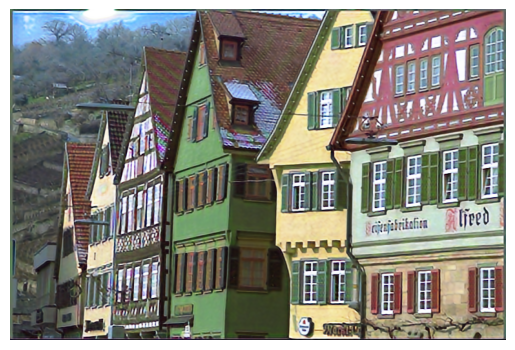

In [ ]:
psnr_all = 0.0
with torch.no_grad():
    stddev = 10 ** (-0.05 * args.base_snr)
    for i in range(times):
        # print(test_image.size())
        if test_image.dim() == 3:
            test_image = test_image.unsqueeze(0)

        model = model.to(device)
        test_image = test_image.to(device)

        demo_image = model(test_image, stddev)
        if isinstance(demo_image, (tuple, list)):
            demo_image = demo_image[0]
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image], dim=1)
    demo_image = demo_image.cpu().numpy()
demo_image = demo_image[0]
demo_image = demo_image[3:, :, :]
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')
print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))
####SNR 13, C = 6 ra e15(17h 12/5) ra 21.87 ; SNR 20 C = 16 e6 ra đẹp nhất là 20.5(10h; 8h30)
